# Analysis of generated data

Analyze experiment results, present findings.

# Import libraries

In [1]:
import pandas as pd  # data manipulation
import os  # interact with directories
import datetime

import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # pretty data visualization
plt.style.use('ggplot')  # plt.style.available

import warnings  # filter warnings
warnings.filterwarnings("ignore")

# Get data

Merge monthly thaitanic order .csv files into single file.

In [2]:
path = "../data/raw_data/"

all_months_data = pd.DataFrame()

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])

# remove unnamed column (fixed for future generations!)
all_months_data = all_months_data.loc[:, ~all_months_data.columns.str.contains('^Unnamed')]
    
# all_months_data.to_csv('all_data.csv', index=False)  # don't want to re-save csv every time

In [3]:
df = pd.read_csv("../data/all_data.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)

df

,Order ID,Product,Quantity Ordered,Price Each,Order Date
0,209412,Tom Yum Gai,1,12,2019-12-31 20:59:00
1,209411,Pad Kee Mao,1,12,2019-12-31 20:57:00
2,209397,Yellow Curry,1,12,2019-12-31 20:55:00
3,209417,Thai Fried Rice,1,12,2019-12-31 20:53:00
4,209402,Yum Woonsen,2,13,2019-12-31 20:51:00
...,...,...,...,...,...
216487,3925,Pad Char,1,15,2017-01-01 12:15:00
216488,3926,Sriracha Wings,1,10,2017-01-01 12:08:00
216489,3913,Grilled Salmon,1,22,2017-01-01 12:07:00
216490,3931,Pad Kee Mao,1,12,2017-01-01 12:06:00


# Clean data

In [4]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
dtype: int64

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.dtypes

Order ID                     int64
Product                     object
Quantity Ordered             int64
Price Each                   int64
Order Date          datetime64[ns]
dtype: object

# Augment data

In [6]:
df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Hour'] = df['Order Date'].dt.hour

# Explore data

There are generic strategies to give more value to customers, although it's unclear if restaurants are the type of business where giving more value directly creates more demand (since they have to see your menu to know about it). There's a business term for this that I'm forgetting. Is it just inelasticity? Or some kind of visibility/accessibility? 
- These are specifically referring to revenue vs expenses.

Let's start by looking at the revenue itself. Their sales are some function of how many meals they're serving and how much they're paying per meal.



### Conceptualize restaurant revenue model

Now that we've seen the data, let's think about what to analyze. We have sales data so let's start by increasing revenue; we can focus on cost efficiency later.


##### (!) may want to explain more clearly here
The company's revenue model can be conceptualized as a product of two major factors:
1. How many people eat at the restaurant? (How many orders will get get?)
2. What do those customers eat? (How much is each order worth?)

We can create a basic revenue model by considering the drivers of those two factors. (Red notes drivers we can directly affect). 

![](revenue_model.jpg)
Here are the questions we can start with (start macro --> micro)
* What hours are the best? (check against sales and orders)
* What items are the most popular? (We can try combo meals instead of simply dropping prices)
##### (?) if we increase value offered, will the cost/order go up?

It's out of scope for this notebook, but you could also consider deeper analysis such as:
* Market trends in the area
* Competitive analysis on other restaurants in the area, especially Thai restaurants

In [7]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Hour
count,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000,216492.000000
mean,106655.919203,1.125427,12.202977,13.733782,2018.009455,6.829329,15.861454
std,59347.187553,0.684673,3.075631,9.269607,0.817747,3.498833,2.958466
min,3910.000000,1.000000,6.000000,6.000000,2017.000000,1.000000,11.000000
25%,55261.750000,1.000000,12.000000,12.000000,2017.000000,4.000000,13.000000
50%,106677.500000,1.000000,12.000000,12.000000,2018.000000,7.000000,17.000000
75%,158065.250000,1.000000,12.000000,12.000000,2019.000000,10.000000,19.000000
max,209428.000000,9.000000,22.000000,198.000000,2019.000000,12.000000,20.000000


We see the lowest Order IDis 3910 - maybe Thaitanic started recording data (or switched to a new system) in December 2016, and just gave us data from January 2017 onwards.

Also we see that at least 75% of order quantites are just one order (but someone ordered 9 somewhere! Maybe catering or some other large takeout option?). 

And we see the cheapest item is six dollars while the most expensive is 22.

### Duplicate values?

In [8]:
df.loc[(df['Order ID'].duplicated())]  # this just shows us there ARE dupe values - about 10k.

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
11,209426,Sticky Rice with Mango,1,6,2019-12-31 20:32:00,6,2019,12,Tuesday,20
13,209427,Sticky Rice with Mango,1,6,2019-12-31 20:29:00,6,2019,12,Tuesday,20
33,209418,Sticky Rice with Mango,1,6,2019-12-31 20:05:00,6,2019,12,Tuesday,20
38,209382,Sticky Rice with Mango,1,6,2019-12-31 19:54:00,6,2019,12,Tuesday,19
54,209386,Pad See Ew,1,12,2019-12-31 19:34:00,12,2019,12,Tuesday,19
...,...,...,...,...,...,...,...,...,...,...
216437,3959,Sticky Rice with Mango,1,6,2017-01-01 13:51:00,6,2017,1,Sunday,13
216462,3936,Sticky Rice with Mango,1,6,2017-01-01 13:00:00,6,2017,1,Sunday,13
216465,3924,Sticky Rice with Mango,3,6,2017-01-01 12:57:00,18,2017,1,Sunday,12
216478,3927,Sticky Rice with Mango,1,6,2017-01-01 12:34:00,6,2017,1,Sunday,12


In [9]:
df.loc[(df['Order ID'] == 209426)]  # example dupe value

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
9,209426,Thai Fried Rice,1,12,2019-12-31 20:32:00,12,2019,12,Tuesday,20
11,209426,Sticky Rice with Mango,1,6,2019-12-31 20:32:00,6,2019,12,Tuesday,20


### Quantity Ordered?

In [10]:
more_than_one_ordered = df.loc[(df['Quantity Ordered'] > 1)]
one_ordered = df.loc[(df['Quantity Ordered'] == 1)]
# len(more_than_one_ordered) + len(one_ordered)
print(len(more_than_one_ordered) / (len(one_ordered) +len(more_than_one_ordered))*100)
more_than_one_ordered

6.55128134065


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
4,209402,Yum Woonsen,2,13,2019-12-31 20:51:00,26,2019,12,Tuesday,20
45,209376,Chicken Satay,2,10,2019-12-31 19:41:00,20,2019,12,Tuesday,19
48,209359,Pad Gra Prow,2,15,2019-12-31 19:38:00,30,2019,12,Tuesday,19
51,209364,Yum Woonsen,3,13,2019-12-31 19:36:00,39,2019,12,Tuesday,19
62,209394,Pumpkin Curry,2,15,2019-12-31 19:25:00,30,2019,12,Tuesday,19
...,...,...,...,...,...,...,...,...,...,...
216429,3978,Thai Streetfood Noodle,9,12,2017-01-01 14:05:00,108,2017,1,Sunday,14
216450,3958,Thai Fried Rice,2,12,2017-01-01 13:18:00,24,2017,1,Sunday,13
216458,3948,Basil Fried Rice,7,12,2017-01-01 13:04:00,84,2017,1,Sunday,13
216464,3924,Sticky Rice with Mango,3,6,2017-01-01 12:57:00,18,2017,1,Sunday,12


We see that about 6.5% of orders have have more than one item ordered.

### Do they have anything in common? Maybe this could inform combos / discounts?

# Best, worst months of sales?

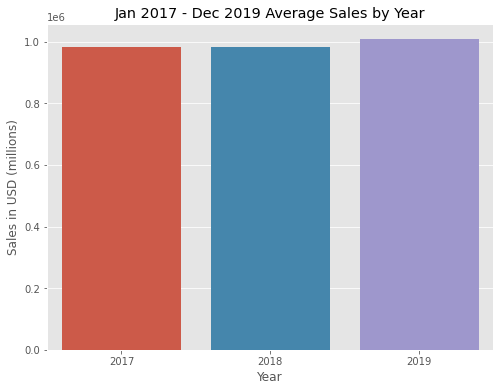

In [11]:
year_sales = df.groupby('Year').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(year_sales.index, year_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Average Sales by Year")
plt.ylabel("Sales in USD (millions)");

Sales look similar between years. Trending upwards, but not significantly enough to note. 2019's sales are 1% higher than 2017's (+$26077 in net sales).

This isn't a new restaurant, so it's likely the demand has settled to the market. It's beyond the scope of this analysis, but you could look at trends for other restaurants in the area to get an idea of how much the area affects sales (as opposed to effort from the restaurant team). 

2019 is also the first year the restaurant exceeded $1M in annual sales. Congrats!

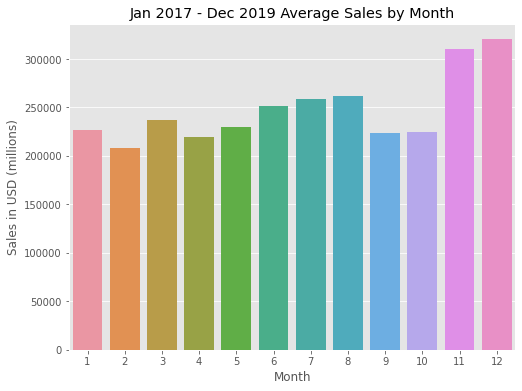

In [12]:
month_sales = df.groupby('Month').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(month_sales.index, month_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Average Sales by Month")
plt.ylabel("Sales in USD (millions)");

There's some variation between monthly sales, but not enough to draw any conclusions other than that November and December have way higher sales. Maybe June/July/August have a slight uptick which doesn't seem unreasonable because of nicer weather and summer break. And maybe September/October have lower values because it's getting colder and people are saving for winter months? 

Let's look by year and by month.

In [13]:
# by year then by month

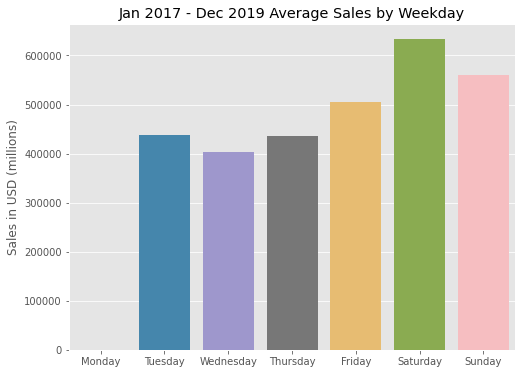

In [14]:
weekday_sales = df.groupby('Weekday').sum()

weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # closed on Mondays
weekday_values = ['Monday']
weekday_sales_values = [0]

for weekday in weekdays:
    weekday_values.append(weekday)
    weekday_sales_values.append(weekday_sales.loc[(weekday_sales.index == weekday)]['Sales'].values[0])

plt.figure(figsize=(8,6))
ax = sns.barplot(weekday_values, weekday_sales_values)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Average Sales by Weekday")
plt.ylabel("Sales in USD (millions)");

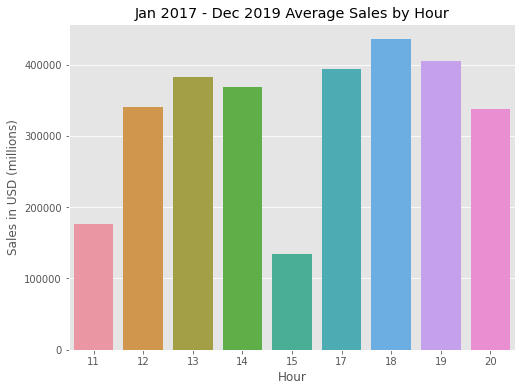

In [15]:
hour_sales = df.groupby('Hour').sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(hour_sales.index, hour_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Average Sales by Hour")
plt.ylabel("Sales in USD (millions)");

This is cool but doesn't tell us much because different weekdays have different hours. We could estimate by adding the 15:00 bar to the 11:00 bar, but we can do better than that.

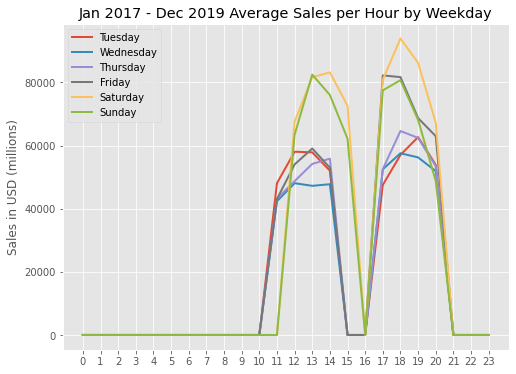

In [18]:
weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,6))

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=2)

plt.xticks(range(0,24))
plt.ylabel("Sales in USD (millions)")
plt.title("Jan 2017 - Dec 2019 Average Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

We can see here that Wednesday is pretty much the lowest day (even lower than Tuesday or Thursday), so maybe switching the off day from Monday to Wednesday might be something to try.

At a glance, you might consider changing up weekday hours from 11am-3pm to 12pm-4pm since the sales are higher there. But we can be pretty sure that weekend hours and customer availability are much better on weekends.

# Item popularity

Look at item popularity, if there's something consistently not popular, maybe they should just get rid of it. That one doesn't even need to be tested.

In [24]:
df.groupby('Product').count().sort_values(by='Quantity Ordered', ascending=False)

,Order ID,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Hour
Product,,,,,,,,,
Sticky Rice with Mango,20609,20609,20609,20609,20609,20609,20609,20609,20609
Green Curry,11208,11208,11208,11208,11208,11208,11208,11208,11208
Red Curry,11194,11194,11194,11194,11194,11194,11194,11194,11194
Pad Thai,11182,11182,11182,11182,11182,11182,11182,11182,11182
Yellow Curry,10970,10970,10970,10970,10970,10970,10970,10970,10970
Thai Beef Noodle Soup,10188,10188,10188,10188,10188,10188,10188,10188,10188
Thai Fried Rice,10075,10075,10075,10075,10075,10075,10075,10075,10075
Thai Streetfood Noodle,10040,10040,10040,10040,10040,10040,10040,10040,10040
Grilled Salmon,9914,9914,9914,9914,9914,9914,9914,9914,9914


Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

# A/B Test suggestions

1. Close on Wednesdays instead of Mondays (if you were really worried, you could try staying open 7 days/week, but I recognize that's not realistic).


# NOTES

I'm just exploring the data. Is there anything specific I can already look for?

1. Sales (break down by times?)


(!) I went to explore the dataset but it's already really clean because I generated it...

(?) should PRODUCT column just be "Order"?

(!) order date is time accurate, not order ID... woops.